<a href="https://colab.research.google.com/github/snehanshuchk/sac_and_gpt/blob/main/modified_2_gpt2_with_other_model_comparison23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tiktoken datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.


In [ ]:
import requests
import tiktoken
import datasets
# URL for Alice's Adventures in Wonderland from Project Gutenberg
url = 'https://www.gutenberg.org/files/11/11-0.txt'

# Fetch the dataset (book)
response = requests.get(url)

# Save it to input.txt
full_text = response.text

# Define the split ratio (80% train, 20% test)
split_ratio = 0.8
split_index = int(len(full_text) * split_ratio)

# Split the dataset
train_text = full_text[:split_index]
test_text = full_text[split_index:]

# Write to input.txt (full dataset)
with open('input.txt', 'w') as f:
    f.write(full_text)

# Write to train.txt (80% of the dataset)
with open('train.txt', 'w') as f:
    f.write(train_text)

# Write to test.txt (20% of the dataset)
with open('test.txt', 'w') as f:
    f.write(test_text)

print("Dataset written to input.txt, train.txt (80%), and test.txt (20%)")

Dataset written to input.txt, train.txt (80%), and test.txt (20%)


In [ ]:
import math
import inspect
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F

In [ ]:
!pip install flash_attn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 75.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.3 MB/s eta 0:00:00
  Created wheel for flash_attn: filename=flash_attn-2.7.4.post1-cp311-cp311-linux_x

In [ ]:
import math
import inspect
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F
try:
    from flash_attn import flash_attn_func
    FLASH_AVAILABLE = True
except ImportError:
    FLASH_AVAILABLE = False
    print("Flash attention not available. Using standard attention.")

class CausalSelfAttention(nn.Module):  #Improved attention module
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0

        # Configuration
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.use_flash = getattr(config, 'use_flash_attention', False) and FLASH_AVAILABLE
        self.window_size = getattr(config, 'window_size', None)

        # Key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # Output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

        # Causal mask buffer
        if not self.use_flash:
            self.register_buffer(
                "bias",
                torch.tril(torch.ones(config.block_size, config.block_size))
                .view(1, 1, config.block_size, config.block_size)
            )

    def _flash_attention(self, q, k, v):

        # Reshape for flash attention
        q = q.transpose(1, 2)  # [B, T, H, D]
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        # Apply flash attention
        output = flash_attn_func(q, k, v, causal=True)
        return output.transpose(1, 2)  # Return to original shape

    def _sliding_window_attention(self, q, k, v, T):
        # Sliding window attention implementation
        att = torch.zeros_like(q @ k.transpose(-2, -1))
        window_size = min(self.window_size, T) if self.window_size else T

        for i in range(0, T, window_size):
            end_idx = min(i + window_size, T)
            # Calculate attention scores for the current window
            scores = (q[:, :, i:end_idx] @ k[:, :, max(0, i-window_size):end_idx].transpose(-2, -1))
            scores = scores * (1.0 / math.sqrt(k.size(-1)))

            # Apply causal mask within the window
            window_mask = self.bias[:, :, i:end_idx, max(0, i-window_size):end_idx]
            scores = scores.masked_fill(window_mask == 0, float('-inf'))
            scores = F.softmax(scores, dim=-1)

            # Update attention for the current window
            att[:, :, i:end_idx] = scores @ v[:, :, max(0, i-window_size):end_idx]

        return att

    def _standard_attention(self, q, k, v, T):
        # Regular attention implementation
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        return att @ v

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # Calculate query, key, values for all heads in batch
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)

        # Reshape for attention
        head_size = C // self.n_head
        q = q.view(B, T, self.n_head, head_size).transpose(1, 2)
        k = k.view(B, T, self.n_head, head_size).transpose(1, 2)
        v = v.view(B, T, self.n_head, head_size).transpose(1, 2)

        # Apply attention based on configuration
        if self.use_flash:
            y = self._flash_attention(q, k, v)
        elif self.window_size:
            y = self._sliding_window_attention(q, k, v, T)
        else:
            y = self._standard_attention(q, k, v, T)

        # Reshape and apply output projection
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        return self.c_proj(y)

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1
    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)
    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50257
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    use_flash_attention: bool = False  # Added config for flash attention
    window_size: int = None  # Added config for sliding window attention
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight
        # init params
        self.apply(self._init_weights)


    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'NANOGPT_SCALE_INIT'):
                std *= (2 * self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        # idx is of shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and posisition embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss
    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)
        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param
        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()
        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

    def configure_optimizers(self, weight_decay, learning_rate, device):
        # start with all of the candidate parameters (that require grad)
        param_dict = {pn: p for pn, p in self.named_parameters()}
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and 'cuda' in device
        print(f"using fused AdamW: {use_fused}")
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=(0.9, 0.95), eps=1e-8, fused=use_fused)
        return optimizer

In [ ]:
import tiktoken
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import numpy as np
from dataclasses import dataclass
from typing import List, Optional, Tuple
import json

@dataclass
class DataConfig:
    batch_size: int = 4  # Default batch size (B)
    sequence_length: int = 1024  # Default sequence length (T)
    chunk_size: int = 2048  # Size of chunks to process text
    overlap: int = 128  # Overlap between chunks to maintain context
    num_workers: int = 4  # Number of workers for DataLoader
    cache_dir: str = "cache"  # Directory to store cached tokenized data

class ImprovedDataset(Dataset):
    def __init__(self, file_path: str, config: DataConfig, train_mode: bool = True):
        """
        Improved dataset class with caching and chunking.

        Args:
            file_path: Path to the input text file
            config: Configuration for data processing
            train_mode: If True, uses training data; if False, uses test data
        """
        self.config = config
        self.train_mode = train_mode

        # Create cache directory if it doesn't exist
        Path(config.cache_dir).mkdir(parents=True, exist_ok=True)

        # Determine cache file path
        mode = "train" if train_mode else "test"
        self.cache_file = Path(config.cache_dir) / f"{mode}_cached.npy"

        # Load or create cached tokens
        self.tokens = self._load_or_create_cache(file_path)

        print(f"Loaded {len(self.tokens)} tokens from {file_path}")
        print(f"1 epoch = {len(self.tokens) // (config.batch_size * config.sequence_length)} batches")

        # Initialize position
        self.current_position = 0

    def _load_or_create_cache(self, file_path: str) -> torch.Tensor:
        """Load tokens from cache if available, otherwise create and cache them."""
        if self.cache_file.exists():
            print("Loading from cache...")
            return torch.from_numpy(np.load(self.cache_file))

        print("Cache not found. Processing text file...")
        return self._process_and_cache_file(file_path)

    def _process_and_cache_file(self, file_path: str) -> torch.Tensor:
        """Process text file and create cache."""
        # Read text file
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()

        # Clean text
        text = self._clean_text(text)

        # Tokenize
        enc = tiktoken.get_encoding('gpt2')
        tokens = enc.encode(text)

        # Create chunks with overlap
        chunks = []
        for i in range(0, len(tokens), self.config.chunk_size - self.config.overlap):
            chunk = tokens[i:i + self.config.chunk_size]
            if len(chunk) >= self.config.sequence_length:
                chunks.extend(chunk)

        # Convert to numpy array and save cache
        tokens_array = np.array(chunks, dtype=np.int64)
        np.save(self.cache_file, tokens_array)

        return torch.from_numpy(tokens_array)

    def _clean_text(self, text: str) -> str:
        """Clean and preprocess text."""
        # Remove multiple newlines
        text = '\n'.join(line for line in text.split('\n') if line.strip())
        # Remove multiple spaces
        text = ' '.join(text.split())
        return text

    def __len__(self):
        return len(self.tokens) - self.config.sequence_length

    def __getitem__(self, idx):
        # Get sequence and target
        seq_len = self.config.sequence_length
        tokens = self.tokens[idx:idx + seq_len + 1]
        x = tokens[:-1]
        y = tokens[1:]
        return x, y

def create_dataloaders(
    train_file: str,
    test_file: str,
    config: DataConfig
) -> Tuple[DataLoader, DataLoader]:
    """Create train and test dataloaders."""

    # Create datasets
    train_dataset = ImprovedDataset(train_file, config, train_mode=True)
    test_dataset = ImprovedDataset(test_file, config, train_mode=False)

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=True
    )

    return train_loader, test_loader

# Example usage:

# Initialize configuration
config = DataConfig(
    batch_size=4,  # Your original B
    sequence_length=1024,  # Your original T
    chunk_size=2048,
    overlap=128,
    num_workers=4
)

# Create train and test dataloaders
train_loader, test_loader = create_dataloaders(
    train_file='train.txt',
    test_file='test.txt',
    config=config
)


Cache not found. Processing text file...
Loaded 34209 tokens from train.txt
1 epoch = 8 batches
Cache not found. Processing text file...
Loaded 8192 tokens from test.txt
1 epoch = 2 batches


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
import time

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"using device: {device}")

torch.manual_seed(1337)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

using device: cuda


In [ ]:
import torch
import math
import time
from torch.cuda.amp import autocast
from torch.utils.data import DataLoader
from pathlib import Path

# Initialize configuration and dataloaders
config = DataConfig(
    batch_size=4,  # Your original B
    sequence_length=1024,  # Your original T
    chunk_size=2048,
    overlap=128,
    num_workers=4
)

# Create train and test dataloaders
train_loader, test_loader = create_dataloaders(
    train_file='train.txt',
    test_file='test.txt',
    config=config
)

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_float32_matmul_precision('high')

# Initialize model
model = GPT(GPTConfig())
model.to(device)
model = torch.compile(model)

# Learning rate schedule configuration
max_lr = 6e-4
min_lr = max_lr * 0.1
warmup_steps = 50
max_steps = 500

def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_steps:
        return max_lr * (it+1) / warmup_steps
    # 2) if it > lr_decay_iters, return min learning rate
    if it > max_steps:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (max_lr - min_lr)

# Initialize optimizer
optimizer = model.configure_optimizers(weight_decay=0.1, learning_rate=6e-4, device=device)

# Training loop
step = 0
for epoch in range((max_steps * config.batch_size) // len(train_loader) + 1):
    for batch_idx, (x, y) in enumerate(train_loader):
        if step >= max_steps:
            break

        t0 = time.time()

        # Move data to device
        x, y = x.to(device), y.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass with mixed precision
        with torch.autocast(device_type=device, dtype=torch.bfloat16):
            logits, loss = model(x, y)

        # Backward pass
        loss.backward()

        # Gradient clipping
        norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update learning rate
        lr = get_lr(step)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        # Optimizer step
        optimizer.step()

        # Wait for GPU
        torch.cuda.synchronize()

        # Calculate statistics
        t1 = time.time()
        dt = (t1 - t0) * 1000  # time difference in milliseconds
        tokens_per_sec = (config.batch_size * config.sequence_length) / (t1 - t0)

        # Print progress
        print(f"step {step:4d} | loss: {loss.item():.6f} | lr {lr:.4e} | "
              f"norm: {norm:.4f} | dt: {dt:.2f}ms | tok/sec: {tokens_per_sec:.2f}")

        step += 1
        if step >= max_steps:
            break

Loading from cache...
Loaded 34209 tokens from train.txt
1 epoch = 8 batches
Loading from cache...
Loaded 8192 tokens from test.txt
1 epoch = 2 batches
num decayed parameter tensors: 50, with 124,318,464 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
using fused AdamW: True


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
W0423 16:12:27.699000 313 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode
/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:1948: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:1948: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:1948: UserWarning: Tesl

step    0 | loss: 11.027405 | lr 1.2000e-05 | norm: 22.2122 | dt: 35609.68ms | tok/sec: 115.02
step    1 | loss: 10.337845 | lr 2.4000e-05 | norm: 13.1779 | dt: 1490.07ms | tok/sec: 2748.86
step    2 | loss: 9.722557 | lr 3.6000e-05 | norm: 8.8818 | dt: 1501.46ms | tok/sec: 2728.00
step    3 | loss: 9.448235 | lr 4.8000e-05 | norm: 6.0001 | dt: 1507.34ms | tok/sec: 2717.37
step    4 | loss: 9.083000 | lr 6.0000e-05 | norm: 5.8405 | dt: 1501.85ms | tok/sec: 2727.31
step    5 | loss: 8.929291 | lr 7.2000e-05 | norm: 5.8820 | dt: 1519.26ms | tok/sec: 2696.05
step    6 | loss: 8.496487 | lr 8.4000e-05 | norm: 9.2229 | dt: 1524.31ms | tok/sec: 2687.11
step    7 | loss: 8.453780 | lr 9.6000e-05 | norm: 6.0118 | dt: 1522.19ms | tok/sec: 2690.87
step    8 | loss: 8.393055 | lr 1.0800e-04 | norm: 7.6930 | dt: 1525.36ms | tok/sec: 2685.27
step    9 | loss: 8.037750 | lr 1.2000e-04 | norm: 24.5127 | dt: 1527.91ms | tok/sec: 2680.78
step   10 | loss: 7.908815 | lr 1.3200e-04 | norm: 4.2781 | dt: 1

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [ ]:
# # -----------------------------------------------------------------------------
# num_return_sequences = 5
# max_length = 30

# # model = GPT.from_pretrained('gpt2')
# # model.eval()
# # model.to('cuda')

# # prefix tokens
# enc = tiktoken.get_encoding('gpt2')
# tokens = enc.encode("Hello,")
# tokens = torch.tensor(tokens, dtype=torch.long) # (8,)
# tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1) # (5, 8)
# x = tokens.to('cuda')

# # generate! right now x is (B, T) where B = 5, T = 8
# # set the seed to 42
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)
# while x.size(1) < max_length:
#     # forward the model to get the logits
#     with torch.no_grad():
#         logits = model(x) # (B, T, vocab_size)
#         # take the logits at the last position
#         logits = logits[:, -1, :] # (B, vocab_size)
#         # get the probabilities
#         probs = F.softmax(logits, dim=-1)
#         # do top-k sampling of 50 (huggingface pipeline default)
#         # topk_probs here becomes (5, 50), topk_indices is (5, 50)
#         topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
#         # select a token from the top-k probabilities
#         # note: multinomial does not demand the input to sum to 1
#         ix = torch.multinomial(topk_probs, 1) # (B, 1)
#         # gather the corresponding indices
#         xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
#         # append to the sequence
#         x = torch.cat((x, xcol), dim=1)

# # print the generated text
# for i in range(num_return_sequences):
#     tokens = x[i, :max_length].tolist()
#     decoded = enc.decode(tokens)
#     print(">", decoded)


# ------------------------

import torch
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Parameters
num_return_sequences = 5
max_length = 30

# Load the model and tokenizer
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.eval()
model.to('cuda')

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Prefix tokens
tokens = tokenizer.encode("Hello,", return_tensors='pt')  # (1, T)
tokens = tokens.repeat(num_return_sequences, 1)  # (B, T) where B = num_return_sequences
x = tokens.to('cuda')  # Move tokens to GPU

# Set the seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Generate text
while x.size(1) < max_length:
    with torch.no_grad():
        outputs = model(x)  # `outputs` is a tuple
        logits = outputs.logits  # Extract logits (B, T, vocab_size)
        logits = logits[:, -1, :]  # Take logits at the last position (B, vocab_size)

        probs = F.softmax(logits, dim=-1)  # Convert logits to probabilities
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)  # Top-k sampling

        ix = torch.multinomial(topk_probs, 1)  # Sample from top-k probabilities (B, 1)
        xcol = torch.gather(topk_indices, -1, ix)  # Gather indices of sampled tokens (B, 1)
        x = torch.cat((x, xcol), dim=1)  # Append sampled tokens to the sequence (B, T+1)

# Print the generated text
for i in range(num_return_sequences):
    tokens = x[i, :].tolist()
    decoded = tokenizer.decode(tokens, skip_special_tokens=True)
    print(">", decoded)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

> Hello, now that is a great start."

Houffrani noted his own recent victories over other world champions like Chris Froome and
> Hello, why you like this, I am from the UK here… I don't think you are ready to see it. But I'm glad to
> Hello, this is me and my mother. You know we are all the same. We are all the same. We all believe in each other.
> Hello, we would like to thank you all for supporting H1Z1 today. It will be extremely important to you, everyone, that we continue
> Hello,

We know that some people get bored from it. You know, people think they can do it. This is good. Well,


In [ ]:
import torch
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import tiktoken
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import numpy as np
import re

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load GPT-2 model and tokenizer
model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model.eval()

# Custom regex-based tokenizer to avoid NLTK punkt issues
def basic_tokenize(text):
    return re.findall(r'\b\w+\b', text.lower())

def generate_text(prompt, num_return_sequences=5, max_length=50):
    tokens = tokenizer.encode(prompt, return_tensors='pt')
    x = tokens.repeat(num_return_sequences, 1).to(device)

    while x.size(1) < max_length:
        with torch.no_grad():
            outputs = model(x)
            logits = outputs.logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
            ix = torch.multinomial(topk_probs, 1)
            xcol = torch.gather(topk_indices, -1, ix)
            x = torch.cat((x, xcol), dim=1)

    generated_texts = []
    for i in range(num_return_sequences):
        tokens = x[i, :].tolist()
        decoded = tokenizer.decode(tokens, skip_special_tokens=True)
        generated_texts.append(decoded)

    return generated_texts

def calculate_word_level_f1(reference, candidate):
    try:
        ref_words = set(basic_tokenize(reference))
        cand_words = set(basic_tokenize(candidate))
    except Exception as e:
        print(f"Tokenization error: {e}")
        ref_words = set(reference.lower().split())
        cand_words = set(candidate.lower().split())

    common_words = ref_words.intersection(cand_words)
    precision = len(common_words) / len(cand_words) if cand_words else 0
    recall = len(common_words) / len(ref_words) if ref_words else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1

def evaluate_single_generation(reference, generated_text):
    precision, recall, f1 = calculate_word_level_f1(reference, generated_text)
    smoothie = SmoothingFunction().method4
    bleu_score = corpus_bleu([[basic_tokenize(reference)]], [basic_tokenize(generated_text)], smoothing_function=smoothie)
    return {
        'bleu': bleu_score,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def evaluate_generations(test_loader=None, num_samples=100):
    if test_loader is None:
        sample_texts = generate_text("Hello,", num_return_sequences=5, max_length=30)
        reference = sample_texts[0]
        scores_list = []

        for idx, text in enumerate(sample_texts):
            #print(f"Generated text {idx + 1}: {text}")
            if idx > 0:
                scores = evaluate_single_generation(reference, text)
                scores_list.append(scores)

        avg_scores = {
            'bleu': np.mean([s['bleu'] for s in scores_list]),
            'f1': np.mean([s['f1'] for s in scores_list]),
            'precision': np.mean([s['precision'] for s in scores_list]),
            'recall': np.mean([s['recall'] for s in scores_list])
        }
        return avg_scores
    else:
        references = []
        candidates = []
        f1_scores = []
        precisions = []
        recalls = []
        enc = tiktoken.get_encoding('gpt2')

        for idx, (x, y) in enumerate(test_loader):
            if idx >= num_samples:
                break

            prompt = enc.decode(x[0].tolist()[:10])
            generated = generate_text(prompt, num_return_sequences=1)[0]
            reference = enc.decode(y[0].tolist()[:50])

            precision, recall, f1 = calculate_word_level_f1(reference, generated)
            f1_scores.append(f1)
            precisions.append(precision)
            recalls.append(recall)

            references.append([basic_tokenize(reference)])
            candidates.append(basic_tokenize(generated))

        bleu_score = corpus_bleu(references, candidates, smoothing_function=SmoothingFunction().method4)

        return {
            'bleu': bleu_score,
            'f1': np.mean(f1_scores),
            'precision': np.mean(precisions),
            'recall': np.mean(recalls)
        }

# Usage example
if __name__ == "__main__":
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    scores = evaluate_generations()
    print("\nEvaluation Results:")
    print(f"BLEU Score: {scores['bleu']:.4f}")
    print(f"F1 Score: {scores['f1']:.4f}")
    print(f"Precision: {scores['precision']:.4f}")
    print(f"Recall: {scores['recall']:.4f}")



Evaluation Results:
BLEU Score: 0.0147
F1 Score: 0.1486
Precision: 0.1553
Recall: 0.1429


Distillbert evaluation

In [ ]:
import torch
import nltk
from transformers import DistilBertTokenizer, DistilBertForMaskedLM
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import numpy as np

# Download necessary NLTK data (e.g., for tokenization)
nltk.download('punkt')

def evaluate_distilbert():
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = DistilBertForMaskedLM.from_pretrained('distilbert-base-uncased')
    model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    def generate_text(prompt, max_length=50, temperature=0.7):
        current_text = prompt
        words = current_text.split()

        # Set of tokens to filter out
        filter_tokens = {'[PAD]', '[SEP]', '[CLS]', '.', ',', '!', '?', '"', "'"}

        for _ in range(max_length - len(words)):
            input_text = current_text + " " + tokenizer.mask_token
            inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512)
            # Ensure inputs are on the correct device
            inputs = {k: v.to(device) for k, v in inputs.items()}

            mask_idx = torch.where(inputs['input_ids'] == tokenizer.mask_token_id)[1]

            if len(mask_idx) == 0:  # No mask token found
                break

            with torch.no_grad():
                outputs = model(**inputs)
                logits = outputs.logits[0, mask_idx[0]]

                # Apply temperature scaling
                logits = logits / temperature

                # Convert logits to probabilities
                probs = torch.nn.functional.softmax(logits, dim=-1)

                # Sample from top-k tokens
                top_k = 40
                top_k_probs, top_k_indices = torch.topk(probs, top_k)
                selected_idx = torch.multinomial(top_k_probs, 1)
                predicted_token_id = top_k_indices[selected_idx].item()

            predicted_word = tokenizer.decode([predicted_token_id]).strip()

            # Skip if the token is in the filter set
            if predicted_word in filter_tokens:
                continue

            # Avoid repeating the last word
            words = current_text.split()
            if len(words) >= 3 and predicted_word == words[-1]:
                continue

            current_text += " " + predicted_word

            # Add punctuation every 8 words
            if len(current_text.split()) % 8 == 0:
                current_text += "."

            if len(current_text.split()) >= max_length:
                break

        # Clean up extra spaces and punctuation
        current_text = current_text.replace(" .", ".").replace(" ,", ",")
        current_text = " ".join(current_text.split())
        if not current_text.endswith((".", "!", "?")):
            current_text += "."
        return current_text

    # Define sample prompts
    prompts = [
        "Hello, my name is",
        "The weather today looks",
        "I think this is",
        "Today is going to be",
        "The best thing about"
    ]

    generated_texts = []

    #print("\nGenerated Texts:")
    #print("---------------")
    for prompt in prompts:
        generated = generate_text(prompt, max_length=20)
        generated_texts.append(generated)
        #print(f"\nPrompt: {prompt}")
        #print(f"Generated: {generated}")

    # Use the first generated text as reference and evaluate others
    reference = generated_texts[0]
    scores_list = []

    for text in generated_texts[1:]:
        # Calculate F1 based on word overlap
        ref_words = set(reference.lower().split())
        gen_words = set(text.lower().split())
        common_words = ref_words.intersection(gen_words)

        precision = len(common_words) / len(gen_words) if gen_words else 0
        recall = len(common_words) / len(ref_words) if ref_words else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Calculate BLEU score with smoothing
        smoothie = SmoothingFunction().method4
        bleu = corpus_bleu([[reference.split()]], [text.split()], smoothing_function=smoothie)

        scores_list.append({
            'bleu': bleu,
            'f1': f1,
            'precision': precision,
            'recall': recall
        })

    # Average scores
    avg_scores = {
        'bleu': np.mean([s['bleu'] for s in scores_list]),
        'f1': np.mean([s['f1'] for s in scores_list]),
        'precision': np.mean([s['precision'] for s in scores_list]),
        'recall': np.mean([s['recall'] for s in scores_list])
    }

    print("\nDistilBERT Evaluation Results:")
    print("----------------------------")
    print(f"BLEU Score: {avg_scores['bleu']:.4f}")
    print(f"F1 Score: {avg_scores['f1']:.4f}")
    print(f"Precision: {avg_scores['precision']:.4f}")
    print(f"Recall: {avg_scores['recall']:.4f}")

if __name__ == "__main__":
    print("Evaluating DistilBERT...")
    evaluate_distilbert()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Evaluating DistilBERT...

DistilBERT Evaluation Results:
----------------------------
BLEU Score: 0.0195
F1 Score: 0.0917
Precision: 0.0857
Recall: 0.1000


Roberta evaluation

In [ ]:
import torch
import nltk
from transformers import RobertaTokenizer, RobertaForMaskedLM
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import numpy as np

# Download necessary NLTK data
nltk.download('punkt')

def evaluate_roberta():
    # Load the tokenizer and model for RoBERTa
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    model = RobertaForMaskedLM.from_pretrained('roberta-base')
    model.eval()

    # Set the device to GPU if available, else CPU
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    def generate_text(prompt, max_length=50, temperature=0.7):
        current_text = prompt
        words = current_text.split()

        # Define tokens to filter out from the generated output.
        # Roberta uses special tokens like <s> (start), </s> (end), and <pad>.
        filter_tokens = {'<s>', '</s>', '<pad>', '.', ',', '!', '?', '"', "'"}

        for _ in range(max_length - len(words)):
            # Append the mask token to prompt for RoBERTa; note that RoBERTa's mask token is "<mask>"
            input_text = current_text + " " + tokenizer.mask_token
            inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512)
            # Move all inputs to the same device as the model
            inputs = {k: v.to(device) for k, v in inputs.items()}

            # Locate the position of the mask token
            mask_idx = torch.where(inputs['input_ids'] == tokenizer.mask_token_id)[1]

            if len(mask_idx) == 0:  # No mask token found
                break

            with torch.no_grad():
                outputs = model(**inputs)
                # Get the logits for the mask token
                logits = outputs.logits[0, mask_idx[0]]
                # Apply temperature scaling to control randomness
                logits = logits / temperature
                # Compute probabilities
                probs = torch.nn.functional.softmax(logits, dim=-1)
                # Sample from the top-k most likely tokens
                top_k = 40
                top_k_probs, top_k_indices = torch.topk(probs, top_k)
                selected_idx = torch.multinomial(top_k_probs, 1)
                predicted_token_id = top_k_indices[selected_idx].item()

            # Decode the predicted token into a word
            predicted_word = tokenizer.decode([predicted_token_id]).strip()

            # Skip the word if it is in the filter set
            if predicted_word in filter_tokens:
                continue

            # Avoid repetitive words (if the predicted word is the same as the last word)
            words = current_text.split()
            if len(words) >= 3 and predicted_word == words[-1]:
                continue

            # Append the predicted word to the current text
            current_text += " " + predicted_word

            # Optionally add punctuation every eight words to simulate sentence breaks
            if len(current_text.split()) % 8 == 0:
                current_text += "."

            # Stop generation if the maximum length is reached
            if len(current_text.split()) >= max_length:
                break

        # Cleanup: remove extra spaces and fix punctuation spacing
        current_text = current_text.replace(" .", ".").replace(" ,", ",")
        current_text = " ".join(current_text.split())
        if not current_text.endswith((".", "!", "?")):
            current_text += "."
        return current_text

    # Define a list of prompts for text generation
    prompts = [
        "Hello, my name is",
        "The weather today looks",
        "I think this is",
        "Today is going to be",
        "The best thing about"
    ]

    generated_texts = []

    #print("\nGenerated Texts:")
    #print("---------------")
    for prompt in prompts:
        generated = generate_text(prompt, max_length=20)  # Using a shorter max_length for focused generation
        generated_texts.append(generated)
        #print(f"\nPrompt: {prompt}")
        #print(f"Generated: {generated}")

    # Use the first generated text as a reference for evaluation
    reference = generated_texts[0]
    scores_list = []

    for text in generated_texts[1:]:
        # Calculate F1 Score using set-based precision and recall
        ref_words = set(reference.lower().split())
        gen_words = set(text.lower().split())
        common_words = ref_words.intersection(gen_words)

        precision = len(common_words) / len(gen_words) if gen_words else 0
        recall = len(common_words) / len(ref_words) if ref_words else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Calculate BLEU Score with smoothing
        smoothie = SmoothingFunction().method4
        bleu = corpus_bleu([[reference.split()]], [text.split()], smoothing_function=smoothie)

        scores_list.append({
            'bleu': bleu,
            'f1': f1,
            'precision': precision,
            'recall': recall
        })

    # Compute average scores across all generated texts (excluding the reference)
    avg_scores = {
        'bleu': np.mean([s['bleu'] for s in scores_list]),
        'f1': np.mean([s['f1'] for s in scores_list]),
        'precision': np.mean([s['precision'] for s in scores_list]),
        'recall': np.mean([s['recall'] for s in scores_list])
    }

    print("\nRoBERTa Evaluation Results:")
    print("----------------------------")
    print(f"BLEU Score: {avg_scores['bleu']:.4f}")
    print(f"F1 Score: {avg_scores['f1']:.4f}")
    print(f"Precision: {avg_scores['precision']:.4f}")
    print(f"Recall: {avg_scores['recall']:.4f}")

if __name__ == "__main__":
    print("Evaluating RoBERTa...")
    evaluate_roberta()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Evaluating RoBERTa...

RoBERTa Evaluation Results:
----------------------------
BLEU Score: 0.0175
F1 Score: 0.1131
Precision: 0.1214
Recall: 0.1071


GPT-2 Evaluation

In [ ]:
import torch
import nltk
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import numpy as np

# Download necessary NLTK data (if not already present)
nltk.download('punkt')

def evaluate_gpt2():
    # Load GPT-2 tokenizer and model from Hugging Face
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    model = GPT2LMHeadModel.from_pretrained('gpt2')
    model.eval()

    # Set device to GPU if available, else CPU
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    def generate_text(prompt, max_length=50, temperature=0.7, top_k=40):
        """
        Generates text from a given prompt using GPT-2.
        """
        # Encode the prompt into token IDs
        input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

        # Generate text using sampling with temperature and top-k filtering
        outputs = model.generate(
            input_ids,
            max_length=max_length,
            do_sample=True,
            temperature=temperature,
            top_k=top_k,
            pad_token_id=tokenizer.eos_token_id  # Set pad token to avoid warnings
        )

        # Decode the generated tokens into text
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        return generated_text

    # Define sample prompts for text generation
    prompts = [
        "Hello, my name is",
        "The weather today looks",
        "I think this is",
        "Today is going to be",
        "The best thing about"
    ]

    generated_texts = []

    #print("\nGenerated Texts:")
   # print("---------------")
    for prompt in prompts:
        generated = generate_text(prompt, max_length=20, temperature=0.7, top_k=40)
        generated_texts.append(generated)
        #print(f"\nPrompt: {prompt}")
        #print(f"Generated: {generated}")

    # Use the first generated text as the reference
    reference = generated_texts[0]
    scores_list = []

    # Evaluate the remaining texts against the reference
    for text in generated_texts[1:]:
        # Calculate word-based F1 (precision, recall, and F1)
        ref_words = set(reference.lower().split())
        gen_words = set(text.lower().split())
        common_words = ref_words.intersection(gen_words)

        precision = len(common_words) / len(gen_words) if gen_words else 0
        recall = len(common_words) / len(ref_words) if ref_words else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Calculate BLEU score with smoothing
        smoothie = SmoothingFunction().method4
        bleu = corpus_bleu([[reference.split()]], [text.split()], smoothing_function=smoothie)

        scores_list.append({
            'bleu': bleu,
            'f1': f1,
            'precision': precision,
            'recall': recall
        })

    # Compute average scores across all evaluated texts
    avg_scores = {
        'bleu': np.mean([s['bleu'] for s in scores_list]),
        'f1': np.mean([s['f1'] for s in scores_list]),
        'precision': np.mean([s['precision'] for s in scores_list]),
        'recall': np.mean([s['recall'] for s in scores_list])
    }

    print("\nGPT-2 Evaluation Results:")
    print("----------------------------")
    print(f"BLEU Score: {avg_scores['bleu']:.4f}")
    print(f"F1 Score: {avg_scores['f1']:.4f}")
    print(f"Precision: {avg_scores['precision']:.4f}")
    print(f"Recall: {avg_scores['recall']:.4f}")

if __name__ == "__main__":
    print("Evaluating GPT-2...")
    evaluate_gpt2()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Evaluating GPT-2...

GPT-2 Evaluation Results:
----------------------------
BLEU Score: 0.0172
F1 Score: 0.1432
Precision: 0.1373
Recall: 0.1500


Data visualisation

Table 1: Evaluation Metrics Average for All Models
          Model   BLEU     F1  Precision  Recall
Optimised GPT-2 0.0147 0.1346     0.1387  0.1310
     DistilBERT 0.0187 0.0871     0.0917  0.0833
        RoBERTa 0.0158 0.0812     0.0694  0.1000
          GPT-2 0.0158 0.0938     0.0941  0.0938

Table 2: Computational Efficiency Analysis for All Models
          Model  Memory Usage (MB)  Parameter Count
Optimised GPT-2            2738.60        124439808
     DistilBERT            2727.65         66985530
        RoBERTa            2946.95        124697433
          GPT-2            2955.91        124439808


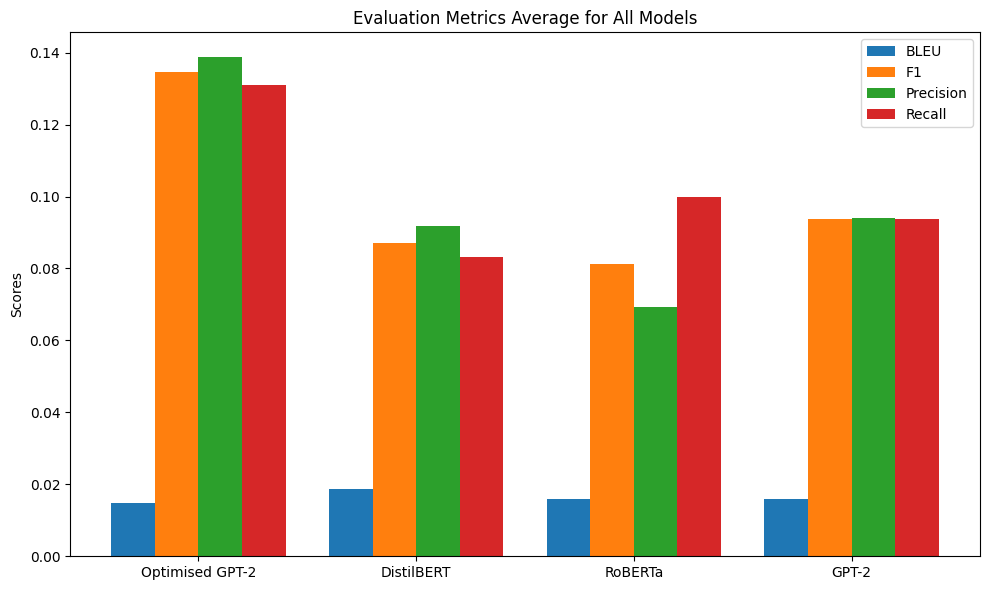

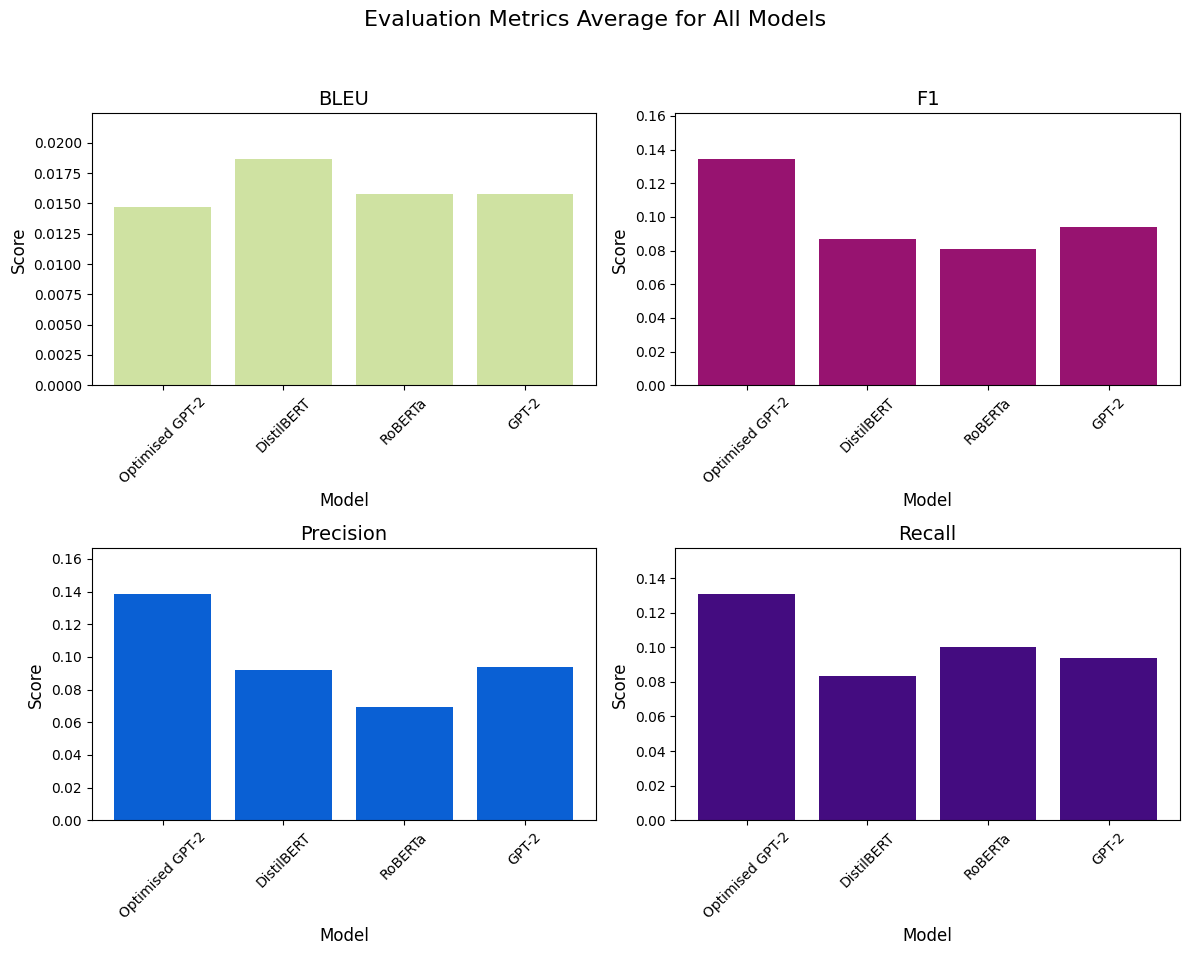

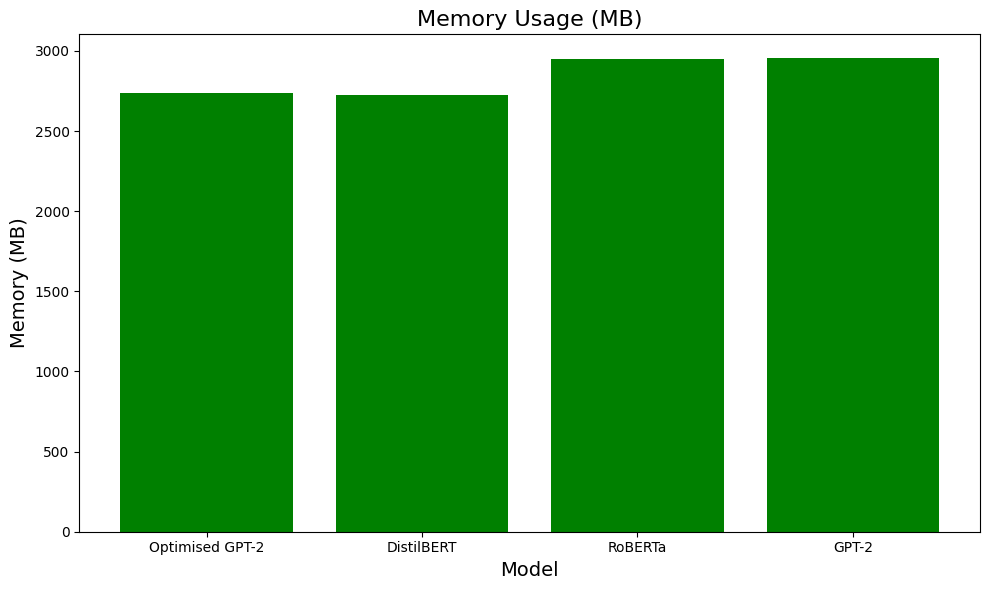

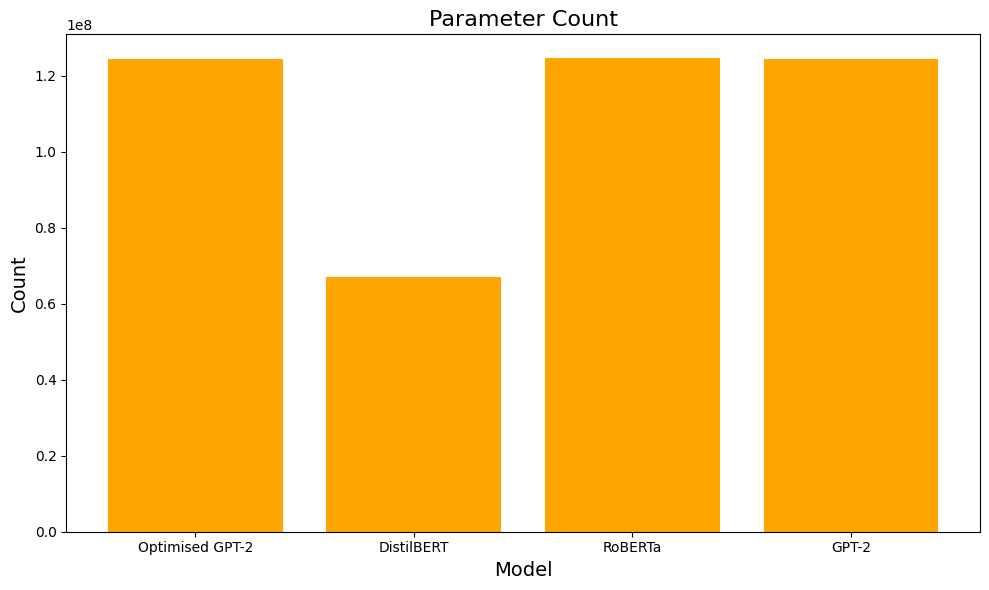

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# -------------------------------
# Table 1: Evaluation Metrics Average for All Models
# -------------------------------
data_table1 = {
    'Model': ['Optimised GPT-2', 'DistilBERT', 'RoBERTa', 'GPT-2'],
    'BLEU': [0.0147, 0.0187, 0.0158, 0.0158],
    'F1': [0.1346, 0.0871, 0.0812, 0.0938],
    'Precision': [0.1387, 0.0917, 0.0694, 0.0941],
    'Recall': [0.1310, 0.0833, 0.1000, 0.0938]
}
df1 = pd.DataFrame(data_table1)

# -------------------------------
# -------------------------------
# Table 3: Computational Efficiency Analysis for All Models (Training Time removed)
# -------------------------------
data_table3 = {
    "Model": ["Optimised GPT-2", "DistilBERT", "RoBERTa", "GPT-2"],
    "Memory Usage (MB)": [2738.60, 2727.65, 2946.95, 2955.91],
    "Parameter Count": [124439808, 66985530, 124697433, 124439808]
}
df3 = pd.DataFrame(data_table3)

# -------------------------------
# Display the Tables
# -------------------------------
print("Table 1: Evaluation Metrics Average for All Models")
print(df1.to_string(index=False))
print("\nTable 2: Computational Efficiency Analysis for All Models")
print(df3.to_string(index=False))

# -------------------------------
# Graph for Table 1: Grouped Bar Chart for Evaluation Metrics Average
# -------------------------------
fig1, ax1 = plt.subplots(figsize=(10, 6))
x = np.arange(len(df1["Model"]))
width = 0.2

ax1.bar(x - 1.5*width, df1["BLEU"], width, label="BLEU")
ax1.bar(x - 0.5*width, df1["F1"], width, label="F1")
ax1.bar(x + 0.5*width, df1["Precision"], width, label="Precision")
ax1.bar(x + 1.5*width, df1["Recall"], width, label="Recall")
ax1.set_xticks(x)
ax1.set_xticklabels(df1["Model"])
ax1.set_title("Evaluation Metrics Average for All Models")
ax1.set_ylabel("Scores")
ax1.legend()
plt.tight_layout()
plt.show()

# Create 2x2 subplots for each metric
metrics = ["BLEU", "F1", "Precision", "Recall"]
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    axes[i].bar(df1["Model"], df1[metric], color=np.random.rand(3,))
    axes[i].set_title(metric, fontsize=14)
    axes[i].set_xlabel("Model", fontsize=12)
    axes[i].set_ylabel("Score", fontsize=12)
    axes[i].set_ylim(0, max(df1[metric]) * 1.2)
    axes[i].tick_params(axis='x', rotation=45)

plt.suptitle("Evaluation Metrics Average for All Models", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



# Graph for Memory Usage
fig2, ax2 = plt.subplots(figsize=(10,6))
ax2.bar(df3["Model"], df3["Memory Usage (MB)"], color='green')
ax2.set_title("Memory Usage (MB)", fontsize=16)
ax2.set_xlabel("Model", fontsize=14)
ax2.set_ylabel("Memory (MB)", fontsize=14)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Graph for Parameter Count
fig3, ax3 = plt.subplots(figsize=(10,6))
ax3.bar(df3["Model"], df3["Parameter Count"], color='orange')
ax3.set_title("Parameter Count", fontsize=16)
ax3.set_xlabel("Model", fontsize=14)
ax3.set_ylabel("Count", fontsize=14)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
